In [79]:
# Assumption: Amenity output is ground truth
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
def load_in_files(encoder_model, ticker):

    folder_path = '/Users/jarrettpennebacker/repos/sentiment_analysis/outputs/'
    files = glob.glob(f'{folder_path}{encoder_model}_fine_tuned_on_margin_{ticker}_*.csv')
    
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True),  pd.read_csv("amenity_extractions.csv")

In [81]:
def format_date_column_in_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.date
    return df

In [82]:
def prepare_columns_for_comparison(encoder_df, amenity_df):
    encoder_df['sentiment'] = encoder_df['sentiment'].replace({'LABEL_1': 'pos', 'LABEL_2': 'neg', 'LABEL_0': 'neutral'})
    amenity_df = amenity_df.rename(columns={'Financial Events Publication Date': 'date', 'Financial Events Polarity': 'sentiment', 'Financial Events Sentence': 'text'})
    return encoder_df, amenity_df

In [83]:
def filter_out_neutral(df):
    return df[~df['sentiment'].isin(['neutral'])]

In [84]:
def sort_and_filter(df, by):
    return df.sort_values(by=by, ascending=False)[by].reset_index(drop=True)

In [85]:
def restrict_date_range(df1, df2):
    df1['date'] = pd.to_datetime(df1['date'])
    df2['date'] = pd.to_datetime(df2['date'])

    # Limit comparison to only days of "smallest" dataset
    start_date = max(df1['date'].min(), df2['date'].min())
    end_date = min(df1['date'].max(), df2['date'].max())

    return df1[(df1['date'] >= start_date) & (df1['date'] <= end_date)], df2[(df2['date'] >= start_date) & (df2['date'] <= end_date)]

In [86]:
def calculate_accuracy_metrics(encoder_df_for_comparison, amenity_df_for_comparison):
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()

    # You might want to combine the texts from both dataframes to ensure the vectorizer learns the full vocabulary
    all_texts = pd.concat([encoder_df_for_comparison['text'], amenity_df_for_comparison['text']]).unique()
    vectorizer.fit(all_texts)

    # Placeholder for matches
    matches = []

    # Iterate over rows in encoder_df_for_comparison
    for index1, row1 in encoder_df_for_comparison.iterrows():
        # Find rows in amenity_df_for_comparison with the same date (and possibly sentiment)
        same_date_df = amenity_df_for_comparison[amenity_df_for_comparison['date'] == row1['date']]
        
        # Vectorize texts for comparison
        text1_vec = vectorizer.transform([row1['text']])
        
        for index2, row2 in same_date_df.iterrows():
            text2_vec = vectorizer.transform([row2['text']])
            
            # Calculate cosine similarity
            sim_score = cosine_similarity(text1_vec, text2_vec)[0][0]
            
            # Consider texts with cosine similarity above a certain threshold as matches
            if sim_score >= 0.7:  # Threshold of 0.8 is just an example; adjust based on your requirements
                matches.append((index1, index2, sim_score, row1['text'], row2['text'], row1['sentiment'], row2['sentiment']))

    # Convert matches to a DataFrame for easier analysis
    matches_df = pd.DataFrame(matches, columns=['Index_df1', 'Index_df2', 'Cosine_Similarity', 'Text_df1', 'Text_df2', 'Sentiment_df1', 'Sentiment_df2'])

    # Identifying (exact matches and) sentiment disagreements
    # exact_matches = matches_df[matches_df['Cosine_Similarity'] == 1]
    sentiment_disagreements = matches_df[(matches_df['Cosine_Similarity'] >= 0.7) & (matches_df['Sentiment_df1'] != matches_df['Sentiment_df2'])]

    # Assuming encoder_df_for_comparison is df1 and amenity_df_for_comparison is df2
    # Mark entries in both dataframes as matched based on cosine similarity comparisons
    # Assuming matches_df contains columns ['Index_df1', 'Index_df2'] referring to original dataframe indices
    encoder_df_for_comparison['matched'] = encoder_df_for_comparison.index.isin(matches_df['Index_df1'])
    amenity_df_for_comparison['matched'] = amenity_df_for_comparison.index.isin(matches_df['Index_df2'])

    # False Positives: Entries in df1 not matched based on cosine similarity
    fp_df1_not_in_df2 = encoder_df_for_comparison[~encoder_df_for_comparison['matched']]

    # False Negatives: Entries in df2 not matched based on cosine similarity
    fn_df2_not_in_df1 = amenity_df_for_comparison[~amenity_df_for_comparison['matched']]

    # Cleanup: You might want to remove the 'matched' columns if they're no longer needed
    encoder_df_for_comparison.drop(columns=['matched'], inplace=True)
    amenity_df_for_comparison.drop(columns=['matched'], inplace=True)

    # Now fp_df1_not_in_df2 and fn_df2_not_in_df1 hold the false positives and negatives considering semantic similarity

    # Calculate Precision and Recall
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # TP (True Positives) = len(matches_df)
    # FP (False Positives) = len(fp_df1_not_in_df2) + len(sentiment_disagreements)
    # FN (False Negatives) = len(fn_df2_not_in_df1)

    true_positives = len(matches_df)
    false_positives = len(fp_df1_not_in_df2) + len(sentiment_disagreements)
    false_negatives = len(fn_df2_not_in_df1)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [96]:
pd.set_option('display.max_colwidth', 1000)

tickers = ['GPS']
encoder_models = ['RoBERTa'] #['ALBERT', 'BERT', 'DistilBERT', 'Electra', 'FinBERT', 'RoBERTa']

scores_dict = {}
for ticker in tickers:
    for encoder_model in encoder_models:
        encoder_df, amenity_df = load_in_files(encoder_model, ticker)
        encoder_df = format_date_column_in_df(encoder_df)
        encoder_df, amenity_df = prepare_columns_for_comparison(encoder_df, amenity_df)
        

        filtered_encoder_df = filter_out_neutral(encoder_df)
        filtered_amenity_df = filter_out_neutral(amenity_df)

        filtered_sorted_encoder_df = sort_and_filter(filtered_encoder_df, ['date', 'text', 'sentiment'])
        filtered_sorted_amenity_df = sort_and_filter(filtered_amenity_df, ['date', 'text', 'sentiment'])

        filtered_sorted_date_restricted_encoder_df, filtered_sorted_date_restricted_amenity_df = restrict_date_range(filtered_sorted_encoder_df, filtered_sorted_amenity_df)

        # Remove this eventually
        pd.concat([filtered_encoder_df.sample(n=40)[['date','sentiment','text','confidence']], encoder_df.sample(n=20)[['date','sentiment','text','confidence']]], ignore_index=False).to_csv(f"{ticker}_{encoder_model}_results_for_review.csv", index=False)

        precision, recall, f1_score = calculate_accuracy_metrics(filtered_sorted_date_restricted_encoder_df, filtered_sorted_date_restricted_amenity_df)
        
        scores_dict[encoder_model] = {
            'precision': precision,
            'recall': recall,
            'f1': f1_score
        }

/var/folders/k7/g3wlfyfj7hx88m5g426q6bx80000gn/T/ipykernel_2368/2891762703.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoder_df_for_comparison['matched'] = encoder_df_for_comparison.index.isin(matches_df['Index_df1'])
/var/folders/k7/g3wlfyfj7hx88m5g426q6bx80000gn/T/ipykernel_2368/2891762703.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoder_df_for_comparison.drop(columns=['matched'], inplace=True)


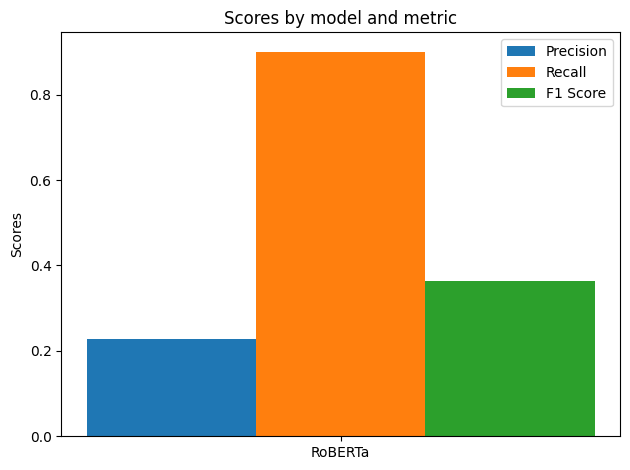

In [88]:
scores_dict_for_bar_chart = copy.deepcopy(scores_dict)

# Extracting model names and their scores into separate lists
models = list(scores_dict_for_bar_chart.keys())
precision = [scores_dict_for_bar_chart[model]['precision'] for model in models]
recall = [scores_dict_for_bar_chart[model]['recall'] for model in models]
f1_scores = [scores_dict_for_bar_chart[model]['f1'] for model in models]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()

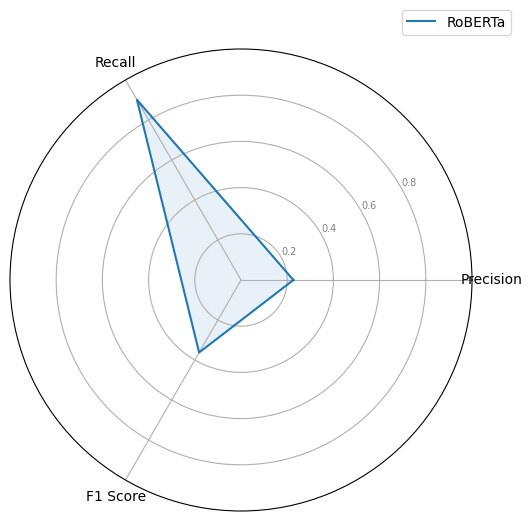

In [89]:
scores_dict_for_bar_chart = scores_dict

# Extracting data for plotting
labels = np.array(['Precision', 'Recall', 'F1 Score'])
model_names = list(scores_dict_for_bar_chart.keys())
stats = np.array([[model_scores['precision'], model_scores['recall'], model_scores['f1']] for model_scores in scores_dict_for_bar_chart.values()])

# Number of variables (i.e., the three metrics)
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The radar chart requires a closed loop, so we append the start value to the end.
stats = np.concatenate((stats, stats[:, [0]]), axis=1)
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0,1)

# Plot and fill for each model
for idx, stat in enumerate(stats):
    ax.plot(angles, stat, label=model_names[idx])
    ax.fill(angles, stat, alpha=0.1)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

In [90]:
pd.read_csv("Recent Insights From Transcripts.csv")['Financial Events Publication Date'].unique()

FileNotFoundError: [Errno 2] No such file or directory: 'Recent Insights From Transcripts.csv'